In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix



In [11]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)
df.head()

,kmeans_dist,kmeans_cluster,dbscan_cluster,pca_1,pca_2,anomaly_score,nearest_cosine_similarity,dengue
0,0.807903,1.00,0.000000,0.690117,0.530614,1.0,0.248749,1.0
1,0.872944,0.25,0.000378,0.548990,0.361146,1.0,0.372575,0.0
2,0.811521,0.00,0.000755,0.402503,0.733854,1.0,0.528842,0.0
3,0.809303,1.00,0.001133,0.472950,0.346633,0.0,0.441506,0.0
4,0.815355,0.00,0.001511,0.601353,0.324567,1.0,0.329382,1.0


In [12]:
X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
class AttentionBinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBinaryClassifier, self).__init__()
        
        # Attention層の重み
        self.attention_weights = nn.Parameter(torch.rand(input_dim))  
        
        # DNN層
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        # Attentionの重み付け
        attention_scores = torch.sigmoid(self.attention_weights) 
        x = x * attention_scores  
        
        # DNNを通して分類
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.output_layer(x))  # 出力層
        return x


In [14]:
# モデルの初期化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_tensor.shape[1]
model = AttentionBinaryClassifier(input_dim=input_dim).to(device)

# 損失関数と最適化
criterion = nn.BCELoss()  # 2値分類
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/200], Loss: 0.6701
Epoch [2/200], Loss: 0.6203
Epoch [3/200], Loss: 0.6116
Epoch [4/200], Loss: 0.6024
Epoch [5/200], Loss: 0.5932
Epoch [6/200], Loss: 0.5855
Epoch [7/200], Loss: 0.5792
Epoch [8/200], Loss: 0.5739
Epoch [9/200], Loss: 0.5689
Epoch [10/200], Loss: 0.5661
Epoch [11/200], Loss: 0.5628
Epoch [12/200], Loss: 0.5598
Epoch [13/200], Loss: 0.5581
Epoch [14/200], Loss: 0.5570
Epoch [15/200], Loss: 0.5556
Epoch [16/200], Loss: 0.5537
Epoch [17/200], Loss: 0.5525
Epoch [18/200], Loss: 0.5519
Epoch [19/200], Loss: 0.5511
Epoch [20/200], Loss: 0.5505
Epoch [21/200], Loss: 0.5491
Epoch [22/200], Loss: 0.5490
Epoch [23/200], Loss: 0.5471
Epoch [24/200], Loss: 0.5462
Epoch [25/200], Loss: 0.5462
Epoch [26/200], Loss: 0.5459
Epoch [27/200], Loss: 0.5446
Epoch [28/200], Loss: 0.5459
Epoch [29/200], Loss: 0.5447
Epoch [30/200], Loss: 0.5452
Epoch [31/200], Loss: 0.5441
Epoch [32/200], Loss: 0.5432
Epoch [33/200], Loss: 0.5422
Epoch [34/200], Loss: 0.5423
Epoch [35/200], Loss: 0

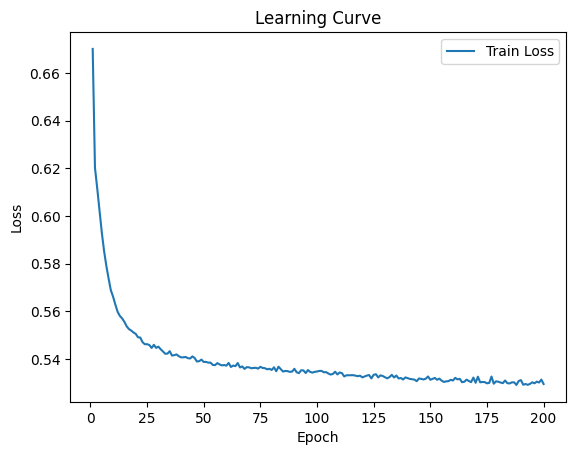

In [15]:
# トレーニング
num_epochs = 200
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# 学習曲線の描画
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Accuracy: 67.25%
Precision: 0.5188
Recall: 0.2648
F1 Score: 0.3506


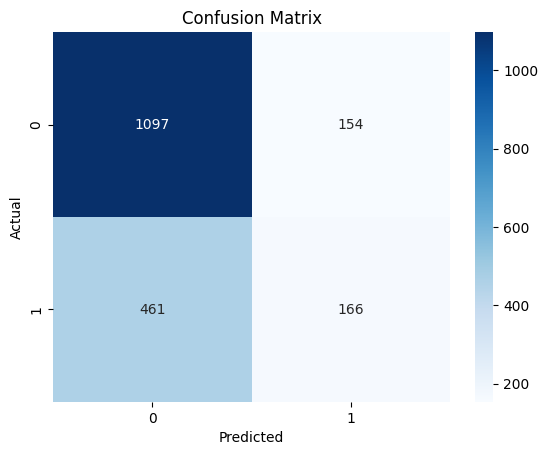

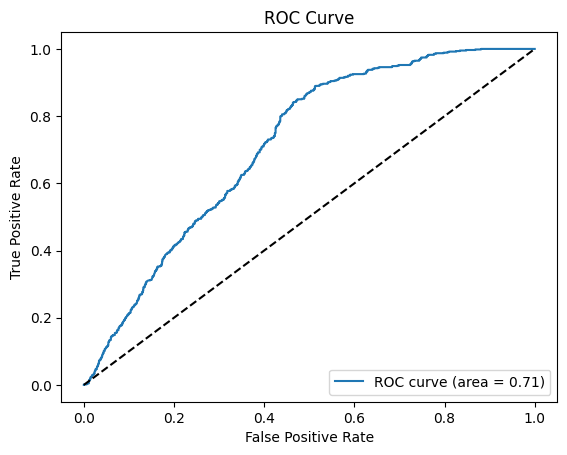

In [16]:
# 評価
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    
    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs > 0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

    # 精度、適合率、再現率、F1スコア
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # 混同行列
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # 45度線
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


最適な閾値: 0.2200, F1スコア: 0.6101
Accuracy: 62.09%
Precision: 0.4646
Recall: 0.8884
F1 Score: 0.6101


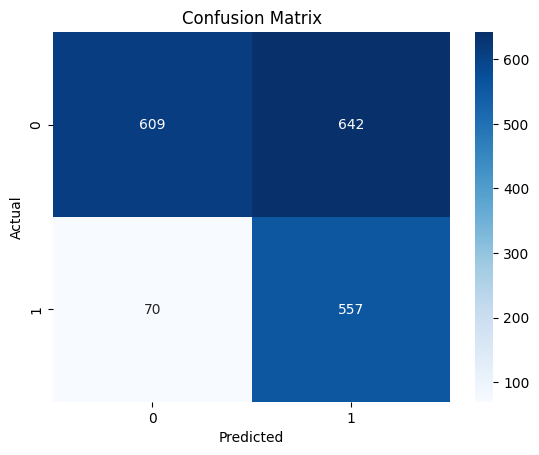

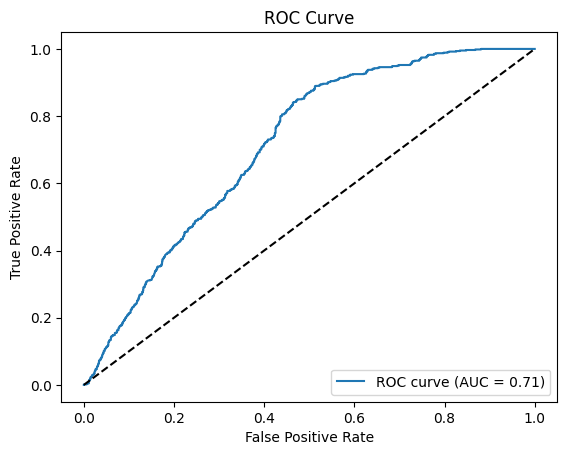

In [17]:
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

# 評価
model.eval()
with torch.no_grad():
    # データをGPUに移行
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()  # モデルからの出力
    y_true = y_test_tensor.cpu().numpy()           # 実際のラベル
    y_prob = test_outputs.cpu().numpy()            # 予測確率

    # 最適な閾値の探索 (例: 0.5を初期値にして精度を確認する)
    optimal_threshold = 0.5  # 初期の閾値
    f1_scores = []
    thresholds = []

    # さまざまな閾値でのF1スコアを計算し、最適なものを見つける
    for threshold in np.linspace(0.0, 1.0, num=101):  # 0.0から1.0までを0.01刻みで
        predictions = (y_prob >= threshold).astype(float)  # 閾値での予測
        f1 = f1_score(y_true, predictions)
        f1_scores.append(f1)
        thresholds.append(threshold)
    
    # 最適なF1スコアとその閾値を取得
    max_f1 = max(f1_scores)
    optimal_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"最適な閾値: {optimal_threshold:.4f}, F1スコア: {max_f1:.4f}")

    # 最適な閾値での予測
    y_pred = (y_prob >= optimal_threshold).astype(float)
    
    # 精度、適合率、再現率、F1スコア
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # 混同行列
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # 45度線
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
